In [7]:
# Defining the graph topology for MAX-CUT
edges = [(0,1), (1,2), (2,3), (3,0)]

def counts(bitstring):
# Initialize an empty dictionary to store the counts
    bitstring_counts = {}

# Count the occurrences of each bitstring
    for x in bitstring:
        if x in bitstring_counts:
            bitstring_counts[x] += 1
        else:
            bitstring_counts[x] = 1
    return bitstring_counts 

def maxcut_obj(x, edges):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    """
    obj = 0
    for i, j in edges:
        if x[i] != x[j]:
            obj -= 1
    return obj

def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, edges)
        avg += obj * count
        sum_count += count

    return avg/sum_count

In [8]:
d = {'0100': 1, '0110': 1, '0101': 1, '1010': 1, '1111': 2, '1001': 1, '0010': 1, '1000': 1, '1011': 1}
compute_expectation(d)

-2.0

In [9]:
x = '1000'
maxcut_obj(x, edges), 8/3

(-2, 2.6666666666666665)

In [10]:
ideal = dict({"0101":1000})
compute_expectation(ideal)

-4.0

In [11]:
import numpy as np  
stat = [0,1]
np.array(stat).min(), np.array(stat).max()

(0, 1)

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

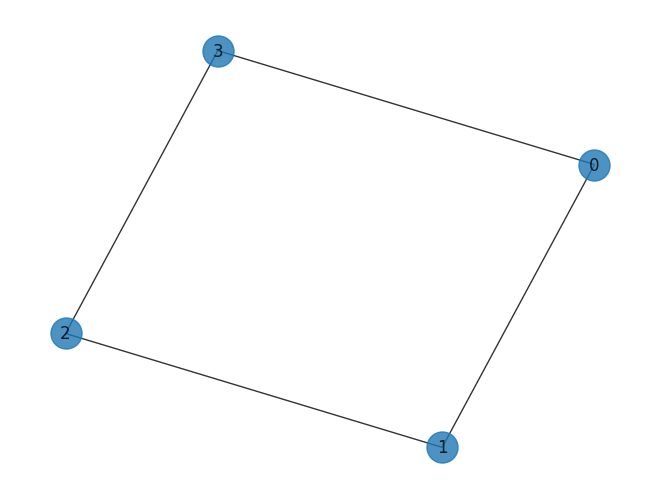

In [13]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

┌───────────────┐
q_0: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_1: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_2: ┤ Rx(2*$\beta$) ├
     ├───────────────┤
q_3: ┤ Rx(2*$\beta$) ├
     └───────────────┘

In [15]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw()

░                              ░      »
q_0: ──■──────────────────────■───░───■──────────────────────■───░──────»
     ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
q_1: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
     └───┘└────────────────┘└───┘ ░   │                      │   ░ ┌─┴─┐»
q_2: ─────────────────────────────░───┼──────────────────────┼───░─┤ X ├»
                                  ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ └───┘»
q_3: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░──────»
                                  ░ └───┘└────────────────┘└───┘ ░      »
«                             ░                              ░ 
«q_0: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_1: ────────────────────■───░──────────────────────────────░─
«     ┌────────────────┐┌─┴─┐ ░                              ░ 
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ 
«q_3: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─
«                             ░ └───┘└────────────────┘└───┘ ░

In [16]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘

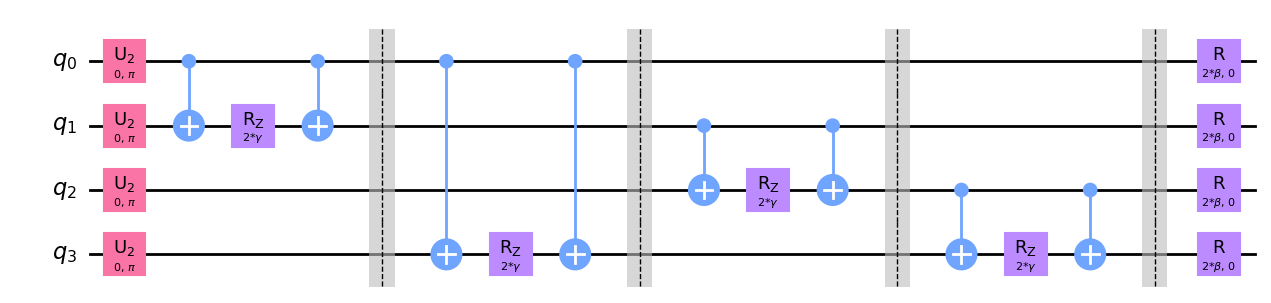

In [55]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw("mpl")

In [59]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.

    Args:
        x: str
           solution bitstring

        G: networkx graph

    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1

    return obj


def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):

    """
    Creates a parametrized qaoa circuit

    Args:
        G: networkx graph
        theta: list
               unitary parameters

    Returns:
        qc: qiskit circuit
    """

    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, p):

        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc


# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):

    """
    Runs parametrized circuit

    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    # backend = provider.get_simulator(num_qubits=len(G.nodes), noisy=False)  # or provider.get_backend(name='Aspen-9')
    aer_sim = Aer.get_backend('aer_simulator')
    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        counts = aer_sim.run(qc, shots=512).result().get_counts()
        # print(counts)
        # res = counts["0000"]/shots
        return compute_expectation(counts, G)
        # return -res

    return execute_circ

In [60]:
get_expectation(G, p=1)((1,1))

-1.46484375

In [61]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation,
                      [1.0, 1.0],
                      method='COBYLA')
res

     fun: -3.07421875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([1.98027371, 1.1680005 ])

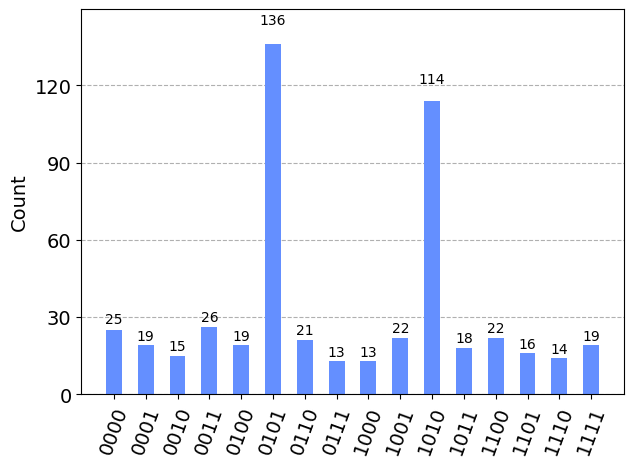

In [62]:
from qiskit.visualization import plot_histogram

# backend = provider.get_simulator(num_qubits=len(G.nodes), noisy=False)
aer_sim = Aer.get_backend('aer_simulator')
# qc_res = create_qaoa_circ(G, res.x)
qc_res = create_qaoa_circ(G, [1,2])

counts = aer_sim.run(qc_res, shots=512).result().get_counts()

plot_histogram(counts)

In [63]:
my_circ = create_qaoa_circ(G, [2.05661852, 1.17497162])

def execute_my_circ(my_circ):
    counts = aer_sim.run(my_circ, shots=1024).result().get_counts()
    return compute_expectation(counts, G)

In [64]:
import numpy as np 
res = []
for _ in range(20):
    res.append((execute_my_circ(my_circ)))
np.array(res).min(), np.array(res).max()

(-3.01171875, -2.859375)

## Distributed computation results

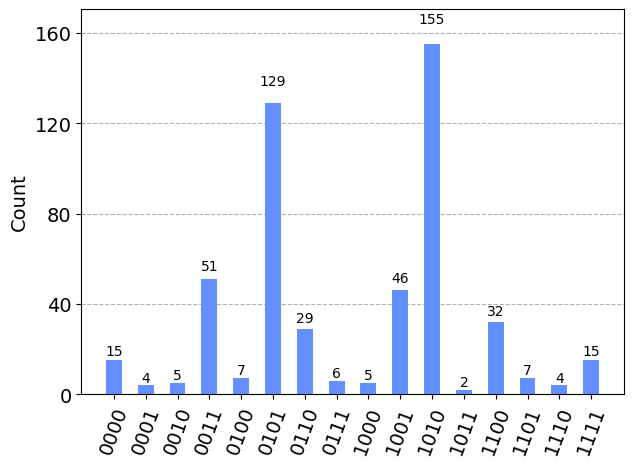

In [66]:
counts_distr = {'1010': 155, '1001': 46, '0110': 29, '0000': 15, '0010': 5, '0101': 129, '0011': 51, '1100': 32, '0100': 7, '1101': 7, '1011': 2, '1111': 15, '1110': 4, '1000': 5, '0111': 6, '0001': 4}

plot_histogram(counts_distr)